# Classification with Support Vector Machines

## The Dataset

This dataset consists of 3921 e-mails to a single account, some of which are spam. These data represent incoming emails for the first three months of 2012 for an email account.

The table has 3921 (1252) observations on the following 21 variables.

* spam: Indicator for whether the email was spam.
* to_multiple: Indicator for whether the email was addressed to more than one recipient.
* from: Whether the message was listed as from anyone (this is usually set by default for regular outgoing email).
* cc: Indicator for whether anyone was CCed.
* sent_email: Indicator for whether the sender had been sent an email in the last 30 days.
* time: Time at which email was sent.
* image: The number of images attached.
* attach: The number of attached files.
* dollar: The number of times a dollar sign or the word “dollar” appeared in the email.
* winner: Indicates whether “winner” appeared in the email.
* inherit: The number of times “inherit” (or an extension, such as “inheritance”) appeared in the email.
* viagra: The number of times “viagra” appeared in the email.
* password: The number of times “password” appeared in the email.
* num_char: The number of characters in the email, in thousands.
* line_breaks: The number of line breaks in the email (does not count text wrapping).
* format: Indicates whether the email was written using HTML (e.g. may have included bolding or active links).
* re_subj: Whether the subject started with “Re:”, “RE:”, “re:”, or “rE:”
* exclaim_subj: Whether there was an exclamation point in the subject.
* urgent_subj: Whether the word “urgent” was in the email subject.
* exclaim_mess: The number of exclamation points in the email message.
* number: Factor variable saying whether there was no number, a small number (under 1 million), or a big number.

The data are from this R package: https://cran.r-project.org/web/packages/openintro/openintro.pdf

In [1]:
# You may need these
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import recall_score, make_scorer, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

## Part A: 

Read in the `email.txt` dataset.

In [2]:
#Reading the email.txt dataset
df = pd.read_csv('email.txt', delimiter='\t')

#Dropping columns that caused trouble
df = df.drop(['time','number', 'winner'], axis='columns')

#Defining X and y
X = df.drop('spam', axis = 'columns')
y = df.spam.values

## Part B: 

Split the data into train and test.  Hold out 50% of observations as the test set.  Pass `random_state=0` to `train_test_split` to ensure you get the same train and tests sets as the solution.

In [3]:
#Splitting the data into training and testing sets 
Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size = 0.5, 
                                                random_state = 0)

## Part C: 

Create a pipeline for your support vector machine.  You can start with a `kernel="linear"` and `gamma="auto"`.

In [4]:
scale_svc_pipe = Pipeline([
    ('scale', MinMaxScaler(feature_range=(-1,1))),
    ('MySVC', SVC(kernel='linear', gamma = 'auto', C = 1) )
])

## Part D: 

Use your model to construct a confusion matrix by fitting and predicting on the training data (I've inlcluded a little helper function to make looking at the confusion matrix a little easier). Then answer the following using the confusion matrix (don't use sklearn's functions):

* What is your model's training accuracy?
* What is your model's training precision?
* What is your model's training recall?

Confusion matrix, without normalization


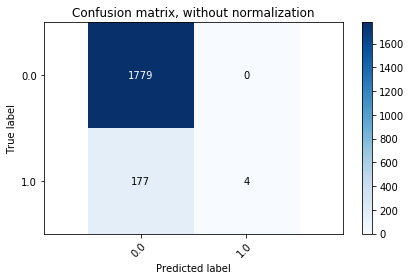

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes=np.array([0.0,1.0]), normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    ax.axis('equal')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax


#Fitting and predicting on the training data 
svm = scale_svc_pipe.fit(Xtrain, ytrain)
y_pred = svm.predict(Xtrain)

#Plotting confusion matrix
plot_confusion_matrix(ytrain, y_pred)

In [6]:
cm = confusion_matrix(ytrain, y_pred)

# Sum of diagonal entries divided by total sum
model_accuracy = np.diag(cm).sum()/cm.sum()

# Bottom right divided by sum of second column
model_precision = cm[1,1]/np.sum(cm[:,1])

# Bottom right divided by sum of second row
model_recall = cm[1,1]/np.sum(cm[1,:])

print(f"Model Accuracy is {model_accuracy:.2f}")
print(f"Model Precision is {model_precision:.2f}")
print(f"Model Recall is {model_recall:.2f}")

Model Accuracy is 0.91
Model Precision is 1.00
Model Recall is 0.02


## Part E: 

Estimate your support vector machine's out of sample recall by using 5 fold cross validation.

In [7]:
scoring = {'rec': 'recall'}

svm_recall = cross_validate(scale_svc_pipe, 
                         Xtrain, 
                         ytrain, 
                         scoring=scoring,
                         cv=5, 
                         return_train_score=True)

print(f"SVM out of sample recall: {svm_recall['test_rec'].mean():.2f}")

SVM out of sample recall: 0.01


## Part F: 

  Use sklearn's `GridSearchCV` to search over the kernel and gamma. Search over `kernel = ['rbf','sigmoid']` and `gamma = np.linspace(1e-5, 1e-2)`.  Use recall as your metric for scoring.
  

`GridSearchCV` is a way to cross validate your models for a variety of parameters.  Read more about `GridSearchCV` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [8]:
param_grid = dict(MySVC__kernel = ['rbf','sigmoid'], 
                 MySVC__gamma = np.linspace(1e-5, 10000))


grid = GridSearchCV(scale_svc_pipe, param_grid, cv=5, scoring='recall')

## Part G: 

What was the cross validated recall for your regularized model?  If you called your model grid search `svc_gscv` you can access the best model's score by performing `svc_gscv.best_score_`.


In [9]:
#Fitting the grid with data
model = grid.fit(Xtrain,ytrain)

print(f"The cross validated recall for the regularized model is: {(grid.best_score_):.2f}")

The cross validated recall for the regularized model is: 0.33


## Part H: 

You can access the results of the cross validation `.cv_results_` method. If you called your estimator `svc_gcsv` then call `svc_gscv.cv_results_`.  This will return a dictionary.  You can turn it into a dataframe using `pandas.DataFrame` (this will make it easier to manipulate).  Learn more about `.cv_results_` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Plot how the mean test error changes as `gamma` changes.  Color the lines according to `kernel`. What do you see happening to the cross validated error as gamma increases?

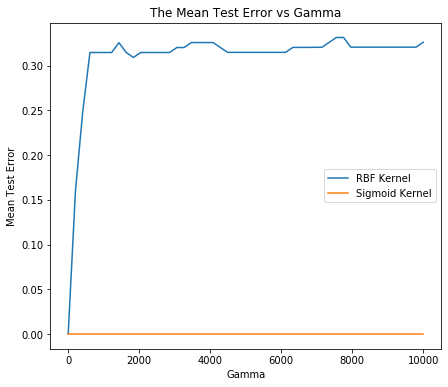

In [10]:
#Turning .cv_results_ into dataframe
cv_results = pd.DataFrame(model.cv_results_)

#Splitting the gamma values and mean test errors by kernel
gamma_rbf = cv_results.loc[cv_results['param_MySVC__kernel'] == 'rbf', 'param_MySVC__gamma']
mean_test_error_rbf = cv_results.loc[cv_results['param_MySVC__kernel'] == 'rbf', 'mean_test_score']

gamma_sigmoid = cv_results.loc[cv_results['param_MySVC__kernel'] == 'sigmoid', 'param_MySVC__gamma']
mean_test_error_sigmoid = cv_results.loc[cv_results['param_MySVC__kernel'] == 'sigmoid', 'mean_test_score']

#Plotting the graph
plt.figure(figsize = (7,6))
plt.plot(gamma_rbf, mean_test_error_rbf, label="RBF Kernel")
plt.plot(gamma_sigmoid, mean_test_error_sigmoid, label="Sigmoid Kernel")
plt.xlabel('Gamma')
plt.ylabel('Mean Test Error')
plt.title('The Mean Test Error vs Gamma')
plt.legend()

#### What do you see happening to the cross validated error as gamma increases?

For the RBF Kernel, the cross validated error initially increased as gamma increased, which make sense because when the gamma value becomes higher it tries to exactly fit the training data set which can lead to overfitting. When gamma was equal to approximetly 1000 and greater, the cross validated error stayed pretty much constant. 

For the Sigmoid Kernel, the cross validated error remained zero for all values of gamma from 1e-5 to 10000.